In [1]:
from common import *

In [2]:
中银多策略混合 = get_fund_data('000572', sdate = '2014-01-01', edate = '2021-02-01')

82
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


In [3]:
中银多策略混合 = 中银多策略混合.set_index('净值日期').sort_index()

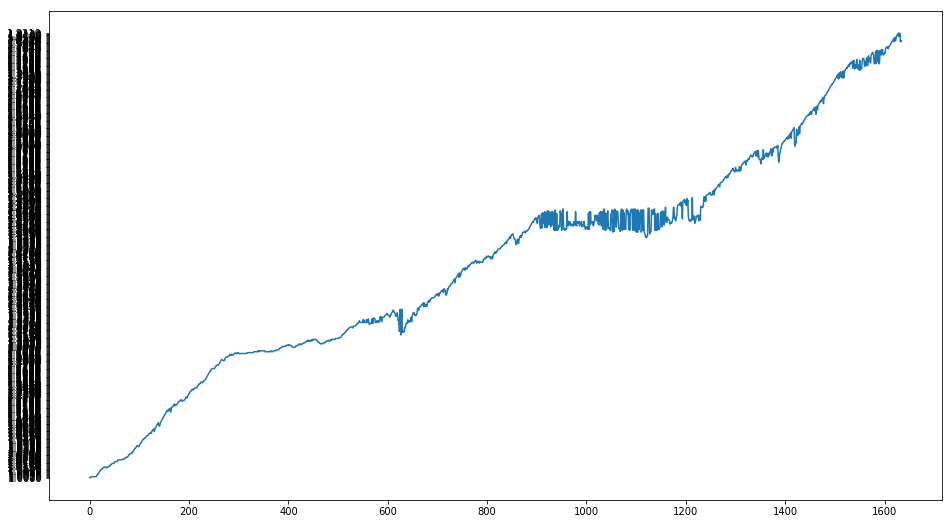

In [4]:
plt.figure(figsize = (16, 9))
plt.plot(中银多策略混合.累计净值.fillna(method='ffill').values)

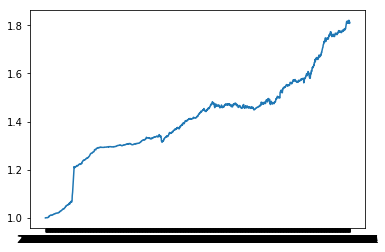

In [22]:
plt.plot(中银多策略混合.累计净值.fillna(method='ffill').astype(float))

In [5]:
沪深300_etf = pd.read_csv('../data/159919_沪深300etf.csv')
沪深300_etf = 沪深300_etf.set_index('净值日期').sort_index()

In [6]:
纳斯达克_etf = pd.read_csv('../data/513100_纳斯达克etf.csv')
纳斯达克_etf = 纳斯达克_etf.set_index('净值日期').sort_index()

In [7]:
黄金_etf = pd.read_csv('../data/518880_黄金etf.csv')
黄金_etf = 黄金_etf.set_index('净值日期').sort_index()

In [8]:
国债 = pd.read_csv(r'../data/159926_国债etf.csv')
国债 = 国债.set_index('净值日期').sort_index()
国债.head()

,单位净值,累计净值,日增长率,申购状态,赎回状态,分红送配
净值日期,,,,,,
2015-01-05,104.308,1.043,0.07%,场内买入,场内卖出,NaN
2015-01-06,104.316,1.043,0.01%,场内买入,场内卖出,NaN
2015-01-07,104.395,1.044,0.08%,场内买入,场内卖出,NaN
2015-01-08,104.380,1.044,-0.01%,场内买入,场内卖出,NaN
2015-01-09,104.352,1.044,-0.03%,场内买入,场内卖出,NaN


In [9]:
total_assert = pd.concat([中银多策略混合.累计净值.rename('中银多策略混合').astype(float),
                          沪深300_etf.累计净值.rename('沪深300_etf'),
                          纳斯达克_etf.累计净值.rename('纳斯达克_etf'),
                          黄金_etf.累计净值.rename('黄金_etf'),
                          国债.累计净值.rename('国债')], axis = 1).sort_index()

In [10]:
total_assert = total_assert.fillna(method = 'ffill').dropna()

In [11]:
s = EqualWeightPortfolio(total_assert)
s.backtest()

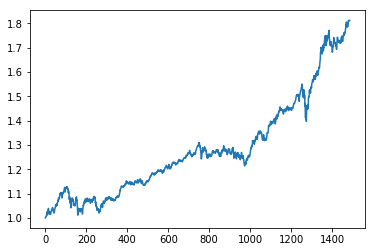

In [12]:
plt.plot(s.get_portfolio_pnl())

In [13]:
def performance(pnl):
    return dict(max_drawdown = get_max_drawdown(pnl), 
                annual_return = get_annual_return(pnl),
                mar = get_mar(pnl))
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.10369238486011366,
 'annual_return': 0.10494038286395369,
 'mar': 1.0120355801009269}

In [14]:
class VolatilityPortfolio(MonthRebalancePortfolio):
    
    '''
        波动率倒数调仓
    '''
    
    def __init__(self, assert_data: pd.DataFrame):
        super(VolatilityPortfolio, self).__init__(assert_data)
        
    def get_rebalanced_weight(self, current_day):
        if current_day < 50:
            return self.portfolio_weight, self.portfolio_cash
        
        portfolio_pnl = self.get_current_portfolio_pnl()
        
        data = self.assert_data.iloc[current_day-40:current_day, :]
        weight = 1.0 / data.pct_change().std().values
        weight = weight / weight.sum()
        
        weight = weight * portfolio_pnl
        return weight, 0.0
        

In [15]:
s = VolatilityPortfolio(total_assert)
s.backtest()

In [16]:
def performance(pnl):
    return dict(max_drawdown = get_max_drawdown(pnl), 
                annual_return = get_annual_return(pnl),
                mar = get_mar(pnl))
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.025225001897453664,
 'annual_return': 0.06657198899004313,
 'mar': 2.6391272143675533}

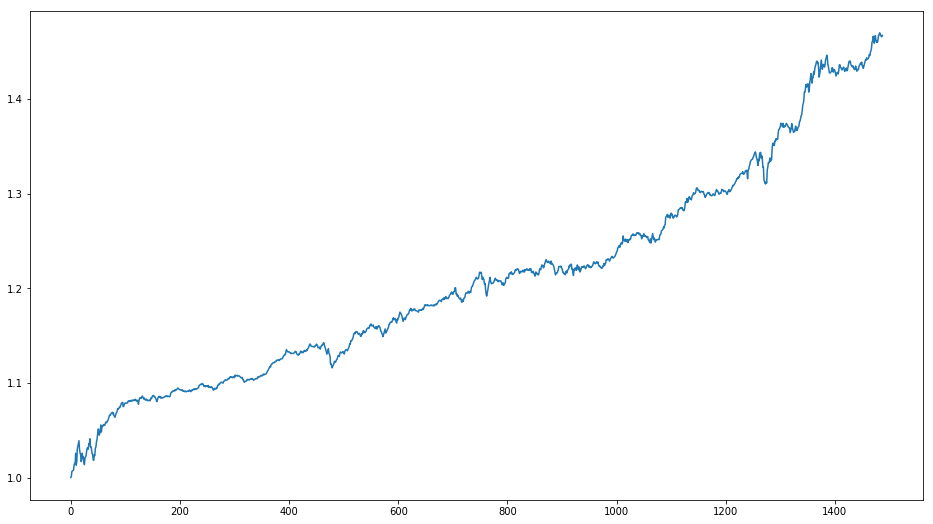

In [17]:
plt.figure(figsize=(16, 9))
plt.plot(s.get_portfolio_pnl())

In [19]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions

class RiskParityPortfolio(MonthRebalancePortfolio):
    
    '''
        风险平价组合
    '''
    
    def __init__(self, assert_data: pd.DataFrame):
        super(RiskParityPortfolio, self).__init__(assert_data)
        
    def get_rebalanced_weight(self, current_day):
#         print('before:', self.portfolio_weight)
        if current_day < 82:
            return self.portfolio_weight, self.portfolio_cash
    
        portfolio_pnl = self.get_current_portfolio_pnl()
  
        count = 0
        new_weights = np.array([0] * self.assert_data.shape[1])
        for period in range(30, 80, 1):
            data = self.assert_data.iloc[current_day-period:current_day, :].copy()
            cov = data.pct_change().cov()
            cov = risk_models.sample_cov(data)
            weights = np.array(calc_equal_risk_contributions_weights(cov.values))
#             print(weights)
            new_weights = new_weights + weights
            count += 1
#         print(count)
        new_weights /= count
    
        # 波动率归一化
#         assert_std = self.assert_data.iloc[current_day - 30:current_day, :].std()
#         new_weights = new_weights / assert_std
#         new_weights = new_weights / new_weights.sum()
#         print(new_weights)
    
        print(new_weights)
    
        new_weights = new_weights * portfolio_pnl
        return new_weights, 0.0
        
        

In [79]:
s = RiskParityPortfolio(total_assert)
s.backtest()

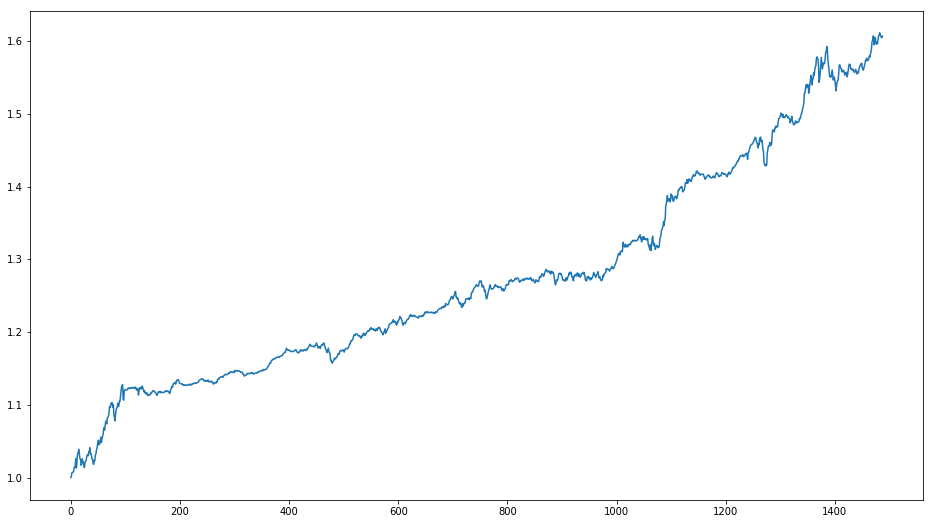

In [80]:
plt.figure(figsize=(16, 9))
plt.plot(s.get_portfolio_pnl())

In [81]:
# 不带波动率优化的组合
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.03830410924372733,
 'annual_return': 0.08293872961661775,
 'mar': 2.1652697648934303}

In [77]:
# 带波动率优化的组合
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.02432291774301796,
 'annual_return': 0.06265190684026423,
 'mar': 2.575838454177597}

In [21]:
total = total_assert.drop('国债', axis = 1)

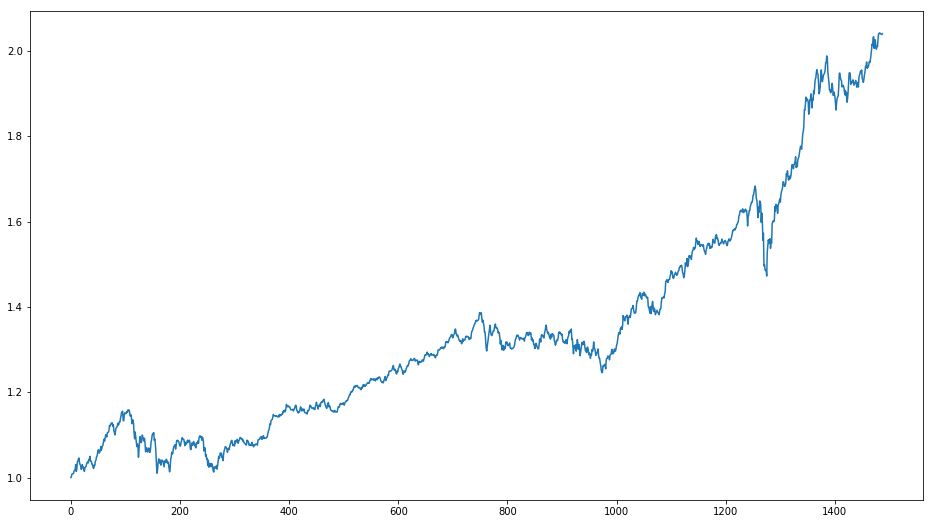

In [22]:
s = EqualWeightPortfolio(total)
s.backtest()

plt.figure(figsize=(16, 9))
plt.plot(s.get_portfolio_pnl())

In [23]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.12842355936387323,
 'annual_return': 0.1272403016217969,
 'mar': 0.9907862875944459}

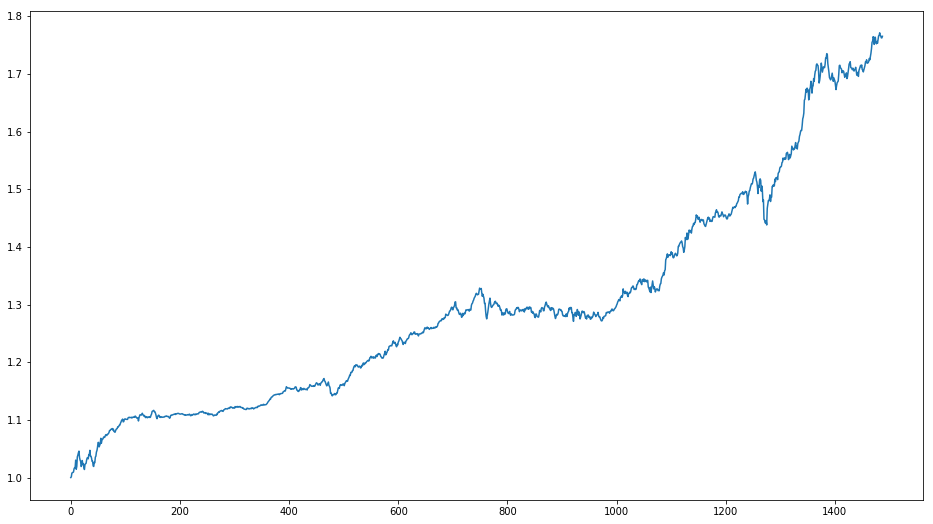

In [24]:
s = VolatilityPortfolio(total)
s.backtest()

plt.figure(figsize=(16, 9))
plt.plot(s.get_portfolio_pnl())

In [90]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.060180644568853345,
 'annual_return': 0.10016853615979415,
 'mar': 1.6644643286462346}

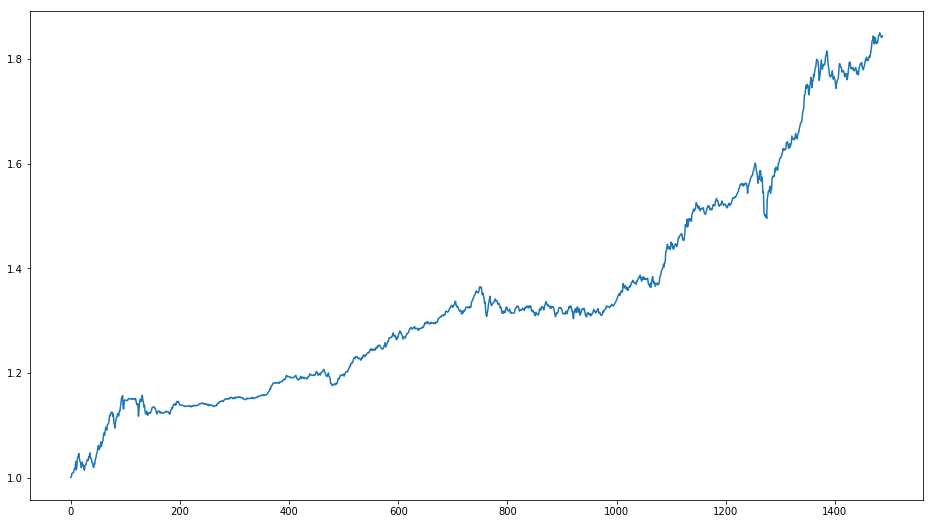

In [94]:
s = RiskParityPortfolio(total)
s.backtest()

plt.figure(figsize=(16, 9))
plt.plot(s.get_portfolio_pnl())

In [95]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.06593732618836151,
 'annual_return': 0.10834124117297761,
 'mar': 1.6430942447299408}

[0.88287887 0.03260217 0.08451896]
[0.70127717 0.06075767 0.23796516]
[0.8947883  0.01826289 0.08694881]
[0.93685952 0.01602494 0.04711554]
[0.94568173 0.01732893 0.03698934]
[0.9637184  0.01294945 0.02333216]
[0.953493   0.01598784 0.03051917]
[0.94201729 0.02064295 0.03733977]
[0.95368123 0.01564059 0.03067819]
[0.95472982 0.01564843 0.02962175]
[0.93667783 0.02205531 0.04126686]
[0.91307526 0.03243432 0.05449042]
[0.90381558 0.0387192  0.05746522]
[0.71483931 0.14722258 0.13793811]
[0.91167395 0.04410911 0.04421694]
[0.83061589 0.06759822 0.10178588]
[0.8115928  0.08353568 0.10487152]
[0.81260443 0.08707766 0.10031791]
[0.79769976 0.11103237 0.09126787]
[0.66170338 0.15358969 0.18470693]
[0.62890504 0.16066525 0.2104297 ]
[0.61666434 0.15110797 0.23222769]
[0.63532638 0.14259432 0.2220793 ]
[0.6306809  0.15391898 0.21540012]
[0.68679685 0.14712008 0.16608307]
[0.7244024 0.14341   0.1321876]
[0.7502197  0.12526088 0.12451942]
[0.78812186 0.09935013 0.11252801]
[0.79926491 0.10072762 

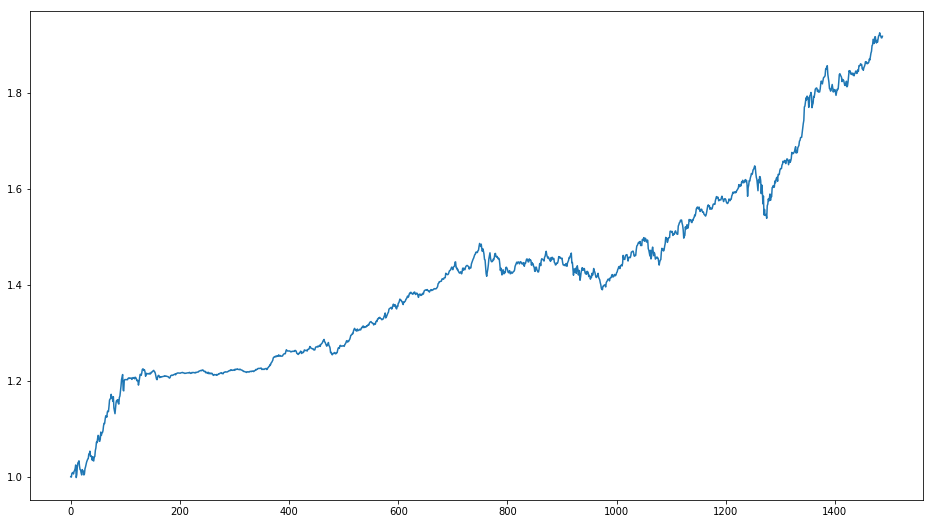

In [25]:
s = RiskParityPortfolio(total.drop('黄金_etf', axis = 1))
s.backtest()

plt.figure(figsize=(16, 9))
plt.plot(s.get_portfolio_pnl())

In [26]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.06634083418670333,
 'annual_return': 0.11572017218614339,
 'mar': 1.744327963384837}

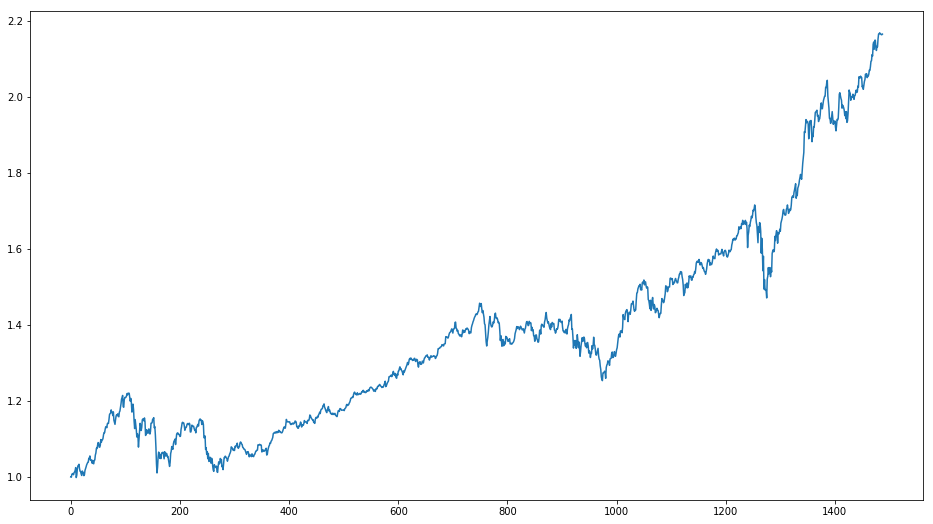

In [101]:
s = EqualWeightPortfolio(total.drop('黄金_etf', axis = 1))
s.backtest()

plt.figure(figsize=(16, 9))
plt.plot(s.get_portfolio_pnl())

In [102]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.1719115572837029,
 'annual_return': 0.1385117218540597,
 'mar': 0.8057150085929128}

In [105]:
total.pct_change().corr()

,中银多策略混合,沪深300_etf,纳斯达克_etf,黄金_etf
中银多策略混合,1.000000,0.470770,0.139462,0.059973
沪深300_etf,0.470770,1.000000,0.207063,-0.041473
纳斯达克_etf,0.139462,0.207063,1.000000,-0.000754
黄金_etf,0.059973,-0.041473,-0.000754,1.000000


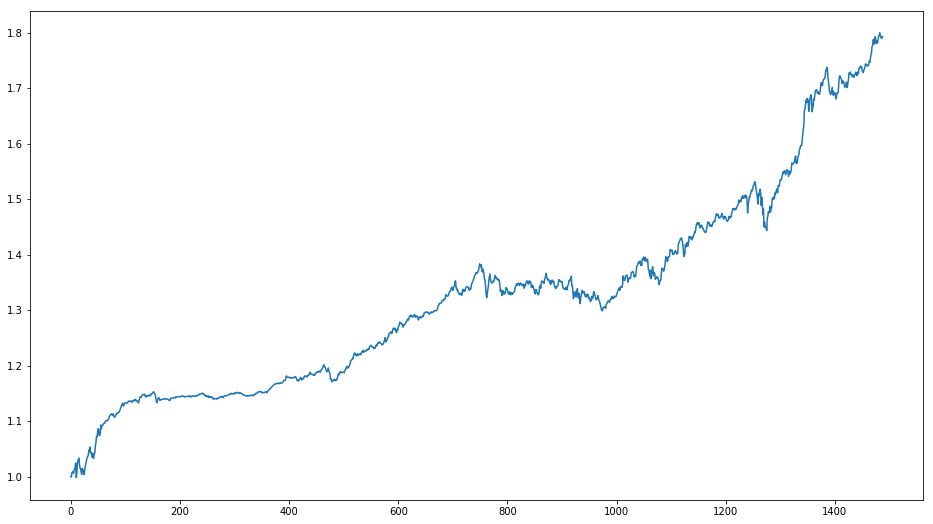

In [91]:
s = VolatilityPortfolio(total.drop('黄金_etf', axis = 1))
s.backtest()

plt.figure(figsize=(16, 9))
plt.plot(s.get_portfolio_pnl())

In [92]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.06114126949460269,
 'annual_return': 0.10304753359176111,
 'mar': 1.685400621275254}

In [18]:
上证50_etf = get_fund_data('510050', sdate = '2014-01-01', edate = '2021-02-01')

87
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


In [36]:
上证50_etf = 上证50_etf.set_index('净值日期').sort_index()

In [37]:
上证50_etf.head()

,单位净值,累计净值,日增长率,申购状态,赎回状态,分红送配
净值日期,,,,,,
2014-01-02,1.5590,2.1390,-0.89%,场内买入,场内卖出,nan
2014-01-03,1.5340,2.1100,-1.60%,场内买入,场内卖出,nan
2014-01-06,1.5110,2.0820,-1.50%,场内买入,场内卖出,nan
2014-01-07,1.5090,2.0800,-0.13%,场内买入,场内卖出,nan
2014-01-08,1.5130,2.0850,0.27%,场内买入,场内卖出,nan


In [67]:
创业板_etf = get_fund_data('159915', sdate = '2014-01-01', edate = '2021-02-01')

87
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


In [70]:
创业板_etf = 创业板_etf.set_index('净值日期').sort_index()

In [71]:
index = pd.concat([上证50_etf.累计净值.astype(float).rename('上证50'), total.沪深300_etf, 创业板_etf.累计净值.astype(float).rename('创业板')], axis = 1)

In [72]:
index = index.fillna(method = 'ffill')

In [73]:
index = index.dropna()
index.head()

,上证50,沪深300_etf,创业板
2015-01-05,3.436,1.4501,1.6298
2015-01-06,3.409,1.4498,1.7110
2015-01-07,3.411,1.4506,1.6928
2015-01-08,3.319,1.4167,1.7122
2015-01-09,3.330,1.4118,1.7239


In [74]:
normalized_index = index / index.iloc[0, ]

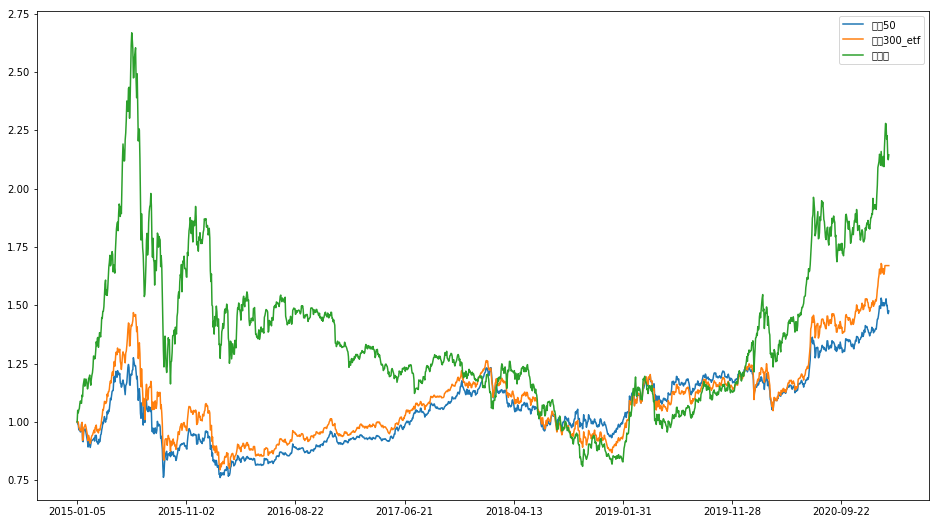

In [75]:
normalized_index.plot(figsize = (16, 9))

In [76]:
performance(index.沪深300_etf)

{'max_drawdown': 0.4590102357028829,
 'annual_return': 0.08999064159532288,
 'mar': 0.19605367069324742}

In [77]:
performance(index.上证50)

{'max_drawdown': 0.4028760556950468,
 'annual_return': 0.06750970170686488,
 'mar': 0.16756940689958924}

In [78]:
performance(index.创业板)

{'max_drawdown': 0.6966770150626652,
 'annual_return': 0.13679151671986434,
 'mar': 0.19634854281443476}

In [81]:
performance((index.沪深300_etf + index.创业板) / 2.0)

{'max_drawdown': 0.5944542625232637,
 'annual_return': 0.11596188004122987,
 'mar': 0.19507283798253822}

In [82]:
new_index = (index.沪深300_etf + index.创业板) / 2.0

In [90]:
total.drop('黄金_etf', axis = 1)

,中银多策略混合,沪深300_etf,纳斯达克_etf
2015-01-05,1.119,1.4501,1.357
2015-01-06,1.130,1.4498,1.341
2015-01-07,1.141,1.4506,1.358
2015-01-08,1.151,1.4167,1.384
2015-01-09,1.164,1.4118,1.375
...,...,...,...
2021-01-26,1.814,2.4218,4.435
2021-01-27,1.813,2.4218,4.435
2021-01-28,1.808,2.4218,4.435
2021-01-29,1.808,2.4218,4.435


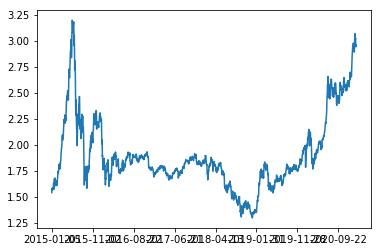

In [93]:
new_index.plot()

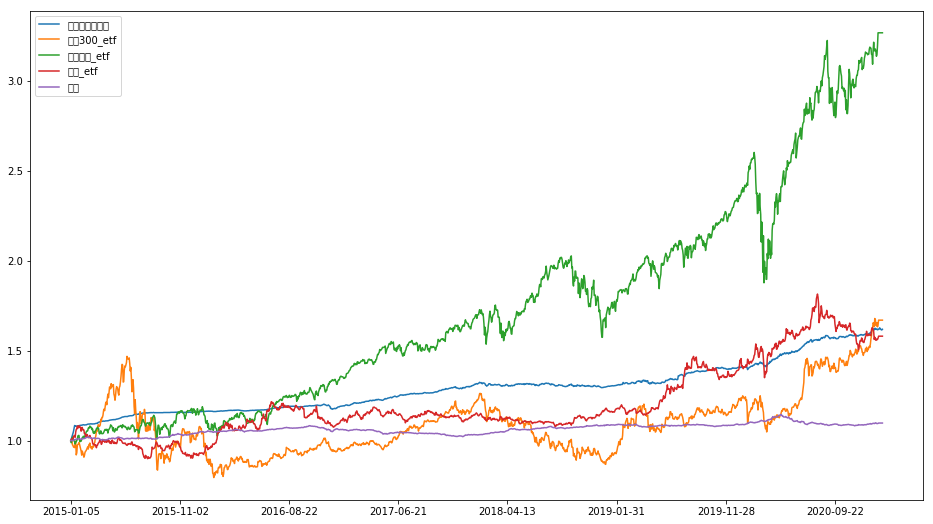

In [96]:
(total_assert / total_assert.iloc[0, :]).plot(figsize = (16, 9))

In [97]:
performance(total.中银多策略混合)

{'max_drawdown': 0.02377414561664192,
 'annual_return': 0.08434972280863517,
 'mar': 3.547960215638214}

[0.88287887 0.03260217 0.08451896]
[0.70127717 0.06075767 0.23796516]
[0.8947883  0.01826289 0.08694881]
[0.93685952 0.01602494 0.04711554]
[0.94568173 0.01732893 0.03698934]
[0.9637184  0.01294945 0.02333216]
[0.953493   0.01598784 0.03051917]
[0.94201729 0.02064295 0.03733977]
[0.95368123 0.01564059 0.03067819]
[0.95472982 0.01564843 0.02962175]
[0.93667783 0.02205531 0.04126686]
[0.91307526 0.03243432 0.05449042]
[0.90381558 0.0387192  0.05746522]
[0.71483931 0.14722258 0.13793811]
[0.91167395 0.04410911 0.04421694]
[0.83061589 0.06759822 0.10178588]
[0.8115928  0.08353568 0.10487152]
[0.81260443 0.08707766 0.10031791]
[0.79769976 0.11103237 0.09126787]
[0.66170338 0.15358969 0.18470693]
[0.62890504 0.16066525 0.2104297 ]
[0.61666434 0.15110797 0.23222769]
[0.63532638 0.14259432 0.2220793 ]
[0.6306809  0.15391898 0.21540012]
[0.68679685 0.14712008 0.16608307]
[0.7244024 0.14341   0.1321876]
[0.7502197  0.12526088 0.12451942]
[0.78812186 0.09935013 0.11252801]
[0.79926491 0.10072762 

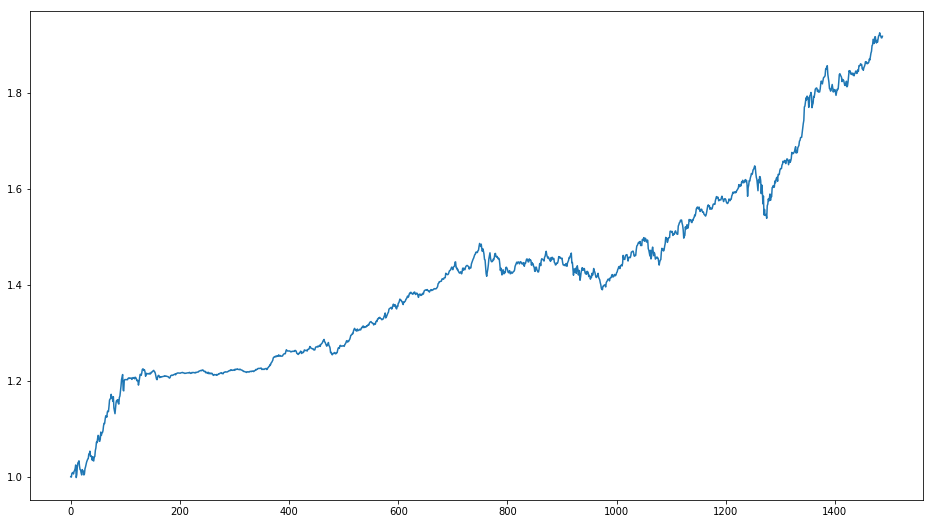

In [98]:
s = RiskParityPortfolio(total.drop('黄金_etf', axis = 1))
s.backtest()

plt.figure(figsize=(16, 9))
plt.plot(s.get_portfolio_pnl())

In [99]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.06634083418670333,
 'annual_return': 0.11572017218614339,
 'mar': 1.744327963384837}

In [100]:
中欧时代先锋 = get_fund_data('001938', sdate = '2014-01-01', edate = '2021-02-01')

64
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [103]:
中欧时代先锋 = 中欧时代先锋.set_index('净值日期').sort_index()

In [104]:
total_assert.head()

,中银多策略混合,沪深300_etf,纳斯达克_etf,黄金_etf,国债
2015-01-05,1.119,1.4501,1.357,0.913,1.043
2015-01-06,1.130,1.4498,1.341,0.920,1.043
2015-01-07,1.141,1.4506,1.358,0.922,1.044
2015-01-08,1.151,1.4167,1.384,0.921,1.044
2015-01-09,1.164,1.4118,1.375,0.921,1.044


In [113]:
total_assert.中银多策略混合

2015-01-05    1.119
2015-01-06    1.130
2015-01-07    1.141
2015-01-08    1.151
2015-01-09    1.164
              ...  
2021-01-26    1.814
2021-01-27    1.813
2021-01-28    1.808
2021-01-29    1.808
2021-02-01    1.812
Name: 中银多策略混合, Length: 1488, dtype: float64

In [133]:
total_3 = pd.concat([中欧时代先锋.累计净值.astype(float).rename('中欧时代先锋'), total_assert.纳斯达克_etf, total_assert.中银多策略混合], axis = 1).sort_index()

In [134]:
total = total_3.fillna(method = 'ffill').dropna()

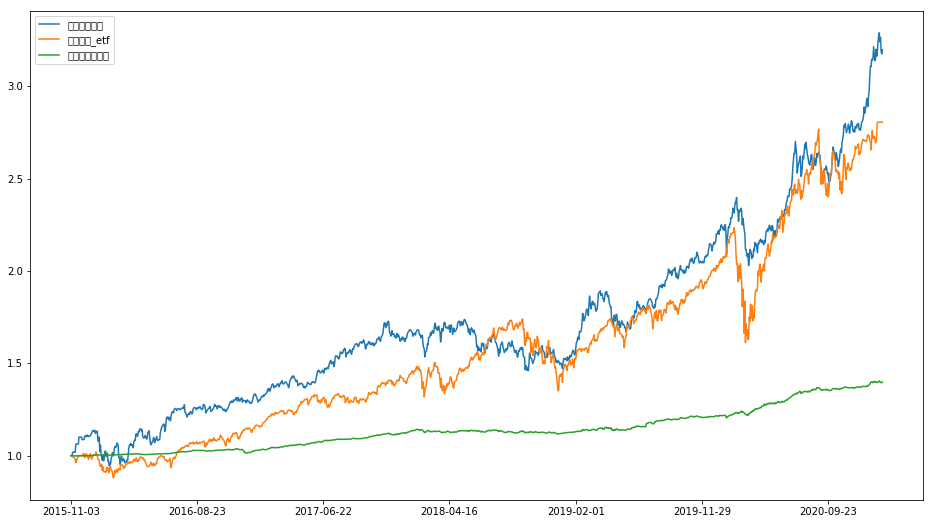

In [137]:
(total / total.iloc[0, :]).plot(figsize = (16, 9))

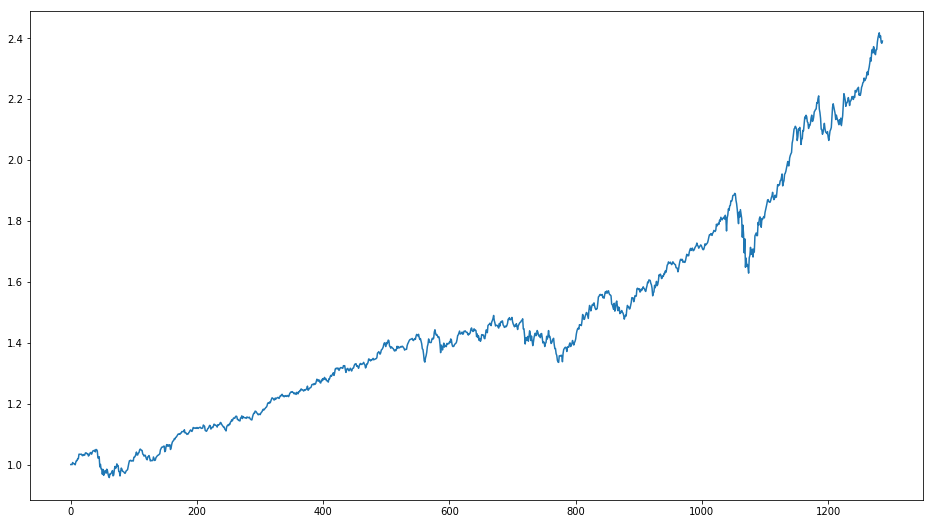

In [140]:
s = EqualWeightPortfolio(total)
s.backtest()

pd.Series(data = s.get_portfolio_pnl()).plot(figsize = (16, 9))

In [141]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.1386254777069568,
 'annual_return': 0.18453918343716613,
 'mar': 1.3312068350614974}

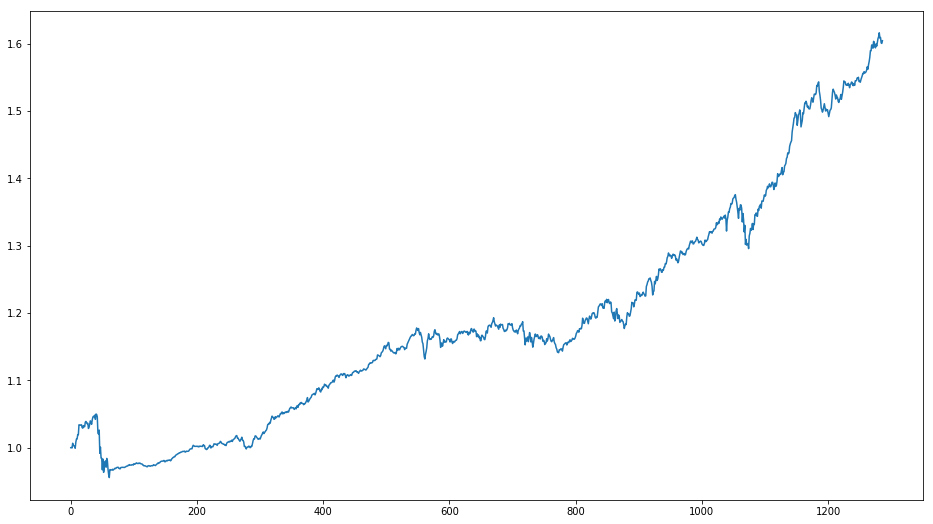

In [142]:
s = VolatilityPortfolio(total)
s.backtest()

pd.Series(data = s.get_portfolio_pnl()).plot(figsize = (16, 9))

In [143]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.08994667176060751,
 'annual_return': 0.09621357511117878,
 'mar': 1.0696735435331126}

[0.02228551 0.04223821 0.93547628]
[0.02899333 0.05685122 0.91415545]
[0.03087696 0.05987746 0.90924558]
[0.15702079 0.21242383 0.63055538]
[0.03445006 0.04782833 0.91772161]
[0.06870075 0.10491623 0.82638302]
[0.08200867 0.10574366 0.81224766]
[0.08634356 0.1027284  0.81092804]
[0.10412919 0.08536923 0.81050157]
[0.16496845 0.16249813 0.67253341]
[0.15992494 0.19151154 0.64856351]
[0.1398549  0.22591841 0.63422669]
[0.12414171 0.22069275 0.65516554]
[0.12559331 0.22080571 0.65360098]
[0.13935508 0.16646971 0.69417521]
[0.15296485 0.13284042 0.71419473]
[0.11361044 0.11562671 0.77076285]
[0.08771482 0.10022522 0.81205996]
[0.13765894 0.13955658 0.72278448]
[0.1212356  0.08672222 0.79204218]
[0.11720004 0.1417092  0.74109076]
[0.12929206 0.18914665 0.68156129]
[0.16196969 0.19339016 0.64464015]
[0.16612799 0.1401045  0.69376752]
[0.12706648 0.10515694 0.76777659]
[0.11817697 0.10044114 0.78138189]
[0.11819009 0.1251103  0.75669961]
[0.10240695 0.16110217 0.73649088]
[0.0958167  0.150532

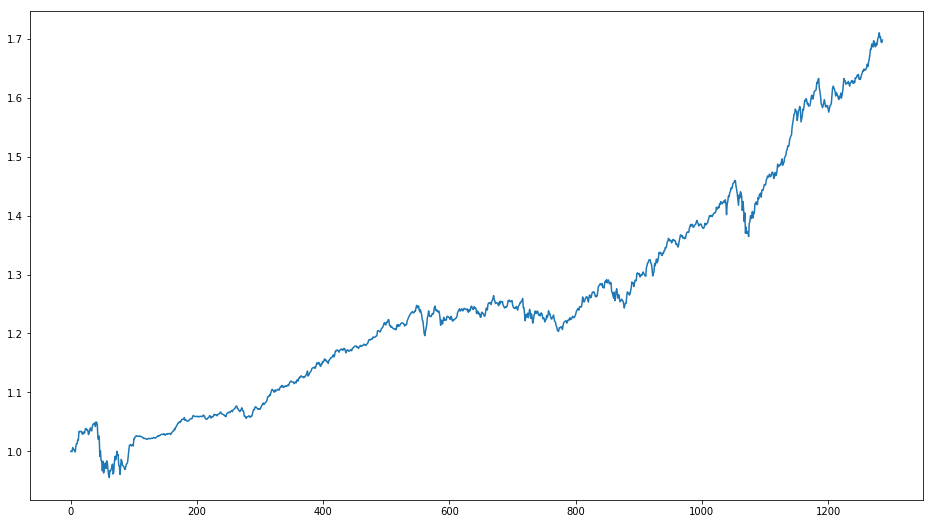

In [144]:
s = RiskParityPortfolio(total)
s.backtest()

pd.Series(data = s.get_portfolio_pnl()).plot(figsize = (16, 9))

In [145]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.08994667176060751,
 'annual_return': 0.10828392237650597,
 'mar': 1.2038680282101257}

In [2]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions

def calc_target_risk_contributions_weights_1(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 0.5),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = calc_portfolio_risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def calc_equal_risk_contributions_weights_1(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return calc_target_risk_contributions_weights_1(target_risk=np.repeat(1/n,n), cov=cov)

class RiskParityPortfolio(MonthRebalancePortfolio):
    
    '''
        风险平价组合
    '''
    
    def __init__(self, assert_data: pd.DataFrame):
        super(RiskParityPortfolio, self).__init__(assert_data)
    
    def get_rebalanced_weight(self, current_day):
#         print('before:', self.portfolio_weight)
        if current_day < 40:
            return self.portfolio_weight, self.portfolio_cash
    
        portfolio_pnl = self.get_current_portfolio_pnl()
  
        count = 0
        new_weights = np.array([0] * self.assert_data.shape[1])
        for period in range(30, 40, 1):
            data = self.assert_data.iloc[current_day-period:current_day, :].copy()
            cov = data.pct_change().cov()
            cov = risk_models.sample_cov(data)
            weights = np.array(calc_equal_risk_contributions_weights_1(cov.values))
#             print(weights)
            new_weights = new_weights + weights
            count += 1
#         print(count)
        new_weights /= count
    
        # 波动率归一化
#         assert_std = self.assert_data.iloc[current_day - 30:current_day, :].std()
#         new_weights = new_weights / assert_std
#         new_weights = new_weights / new_weights.sum()
#         print(new_weights)
    
        print(new_weights)
    
        new_weights = new_weights * portfolio_pnl
        return new_weights, 0.0
        
        

In [7]:
total.head()

ImportError: cannot import name '_is_url' from 'pandas.io.common' (/home/xingxing/anaconda3/lib/python3.7/site-packages/pandas/io/common.py)

            中欧时代先锋  纳斯达克_etf  中银多策略混合
index                                
2015-11-03   1.000     1.581    1.296
2015-11-04   1.000     1.582    1.296
2015-11-05   1.000     1.579    1.296
2015-11-06   1.019     1.582    1.296
2015-11-09   1.019     1.567    1.296

In [199]:
total.reset_index().to_csv('../data/total.csv', index = 0)

In [3]:
total = pd.read_csv(r'../data/total.csv').set_index('index')

In [4]:
s = RiskParityPortfolio(total)
s.backtest()

pd.Series(data = s.get_portfolio_pnl()).plot(figsize = (16, 9))

AttributeError: 'RiskParityPortfolio' object has no attribute 'assert_num'

In [191]:
performance(s.get_portfolio_pnl())

{'max_drawdown': 0.11207713606877516,
 'annual_return': 0.15765814000034317,
 'mar': 1.4066931537543717}

In [189]:
s.get_daily_std()

AttributeError: 'RiskParityPortfolio' object has no attribute 'get_daily_std'